# Initialization

In [225]:
import pandas as pd 
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer,ENGLISH_STOP_WORDS,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, roc_auc_score
from nltk.tokenize import word_tokenize

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb 


# Data import DJIA

In [176]:
apple = pd.read_csv(r'C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Stock_from_sentiment/Data/AAPL.csv')
apple.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,News
0,12/1/2006,13.114285,13.190000,12.871428,91.320000,13.045714,198769900,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...
1,12/4/2006,13.125714,13.150000,12.928572,91.120003,13.017143,177384200,More on Housing Prices : The broadest governme...
2,12/6/2006,12.948571,13.055715,12.810000,89.830002,12.832857,159546100,Honoring R.W. Apple in Words and Food : About ...
3,12/7/2006,12.861428,12.928572,12.414286,87.040001,12.434286,251206900,"Homebuilders, and Worries Over Jobs, Lead a De..."
4,12/8/2006,12.461429,12.770000,12.428572,88.259995,12.608571,196069300,"Homebuilders, and Worries Over Jobs, Lead a De..."


In [177]:
micro = pd.read_csv(r'C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Stock_from_sentiment/Data/MSFT.csv')
micro.head(5)

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,News
0,1.0,12/4/2006,29.230000,29.520000,29.170000,29.330000,29.330000,55123400,The Retooling of a Search Engine : Ask.com is ...
1,NaN,12/6/2006,29.100000,29.129999,28.870001,28.990000,28.990000,48564100,Combat as Usual? Not With These Games : A few ...
2,3.0,12/7/2006,28.959999,29.070000,28.809999,28.850000,28.850000,46831100,Vista Is Ready. Are You? : Why it might be a b...
3,4.0,12/12/2006,29.559999,29.629999,29.219999,29.430000,29.430000,68529400,Take the Hotel Room Home : Hotels have become ...
4,NaN,12/13/2006,29.600000,29.600000,29.320000,29.549999,29.549999,46002500,Google to Offer Variation on Stock Options : G...


# Data exploration

In [178]:
apple.shape

(2323, 8)

In [179]:
sents=[]
apple_news=''
micro_news=''
sents=[sent for sent in apple.News]
for j in range(len(sents)):
    apple_news=apple_news+str(sents[j])
sents=[]
sents=[sent for sent in micro.News]
for j in range(len(sents)):
    micro_news=micro_news+str(sents[j])


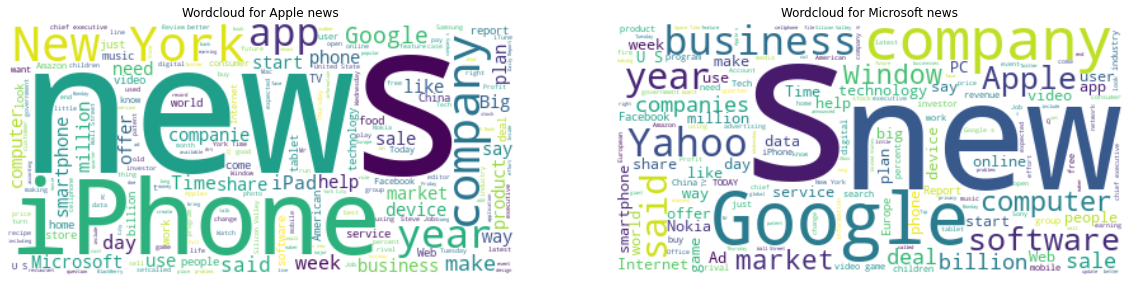

In [180]:
apples=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['Apple']), background_color='white').generate(apple_news)
micros=WordCloud(stopwords=ENGLISH_STOP_WORDS.union(['Microsoft']), background_color='white').generate(micro_news)

fig,ax=plt.subplots(ncols=2,figsize=(20,10))
ax[0].set_title('Wordcloud for Apple news')
ax[0].imshow(apples,interpolation='bilinear')
ax[0].axis('off')

ax[1].set_title('Wordcloud for Microsoft news')
ax[1].imshow(micros,interpolation='bilinear')
ax[1].axis('off')

plt.show()

# Data preparation

In [181]:
apple['Bullish']=(apple.Close>apple.Open).astype('category')
micro['Bullish']=(micro.Close>micro.Open).astype('category')


In [182]:
apple.drop(['Date','Open','High','Low','Close','Adj Close','Volume'],axis=1,inplace=True)
micro.drop(['Date','Open','High','Low','Close','Adj Close','Volume'],axis=1,inplace=True)

In [183]:
apple.Bullish=apple.Bullish.astype('int')
micro.Bullish=micro.Bullish.astype('int')

# Feature extraction

In [184]:
apple.head(3)

,News,Bullish
0,WHAT'S ON TONIGHT : 8 P.M. (TLC) ASHLEY JUDD A...,1
1,More on Housing Prices : The broadest governme...,1
2,Honoring R.W. Apple in Words and Food : About ...,1


In [185]:
cnt1=CountVectorizer(lowercase=True, stop_words=ENGLISH_STOP_WORDS,token_pattern=r"\w+", ngram_range=(1,5),max_features=200, min_df=2)
cnt2=CountVectorizer(lowercase=True, stop_words=ENGLISH_STOP_WORDS,token_pattern=r'\w+', ngram_range=(1,5),max_features=200, min_df=2)

In [186]:
apple_x=apple.News
apple_y=apple.Bullish
msft_x=micro.News
msft_y=micro.Bullish

# Model building

In [187]:
apple_X_train,apple_X_test, apple_y_train, apple_y_test=train_test_split(apple_x,apple_y, test_size=0.2, stratify=apple_y, random_state=12345)
msft_X_train,msft_X_test, msft_y_train, msft_y_test=train_test_split(msft_x,msft_y, test_size=0.2, stratify=msft_y, random_state=12345)

In [188]:
apple_X_train=cnt1.fit_transform(apple_X_train).A
msft_X_train=cnt2.fit_transform(msft_X_train).A
apple_X_test=cnt1.transform(apple_X_test).A
msft_X_test=cnt2.transform(msft_X_test).A

In [189]:
apple_X_train = pd.DataFrame(apple_X_train,columns=cnt1.get_feature_names())
msft_X_train = pd.DataFrame(msft_X_train,columns=cnt2.get_feature_names())
apple_X_test = pd.DataFrame(apple_X_test,columns=cnt1.get_feature_names())
msft_X_test = pd.DataFrame(msft_X_test,columns=cnt2.get_feature_names())

In [226]:
def scorer(model,X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    acc = accuracy_score(y_test,predictions)
    prec= precision_score(y_test,predictions)
    aucroc=roc_auc_score(y_test,predictions)
    return acc,prec,aucroc

## Apple

In [268]:
logistic=pd.Series([*scorer(LogisticRegression(solver='saga'),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
knn=pd.Series([*scorer(KNeighborsClassifier(n_neighbors=2),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
svm=pd.Series([*scorer(SVC(kernel='linear'),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
nb=pd.Series([*scorer(BernoulliNB(),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
gnb=pd.Series([*scorer(GaussianNB(),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
tree=pd.Series([*scorer(DecisionTreeClassifier(),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
rf=pd.Series([*scorer(RandomForestClassifier(),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
ada=pd.Series([*scorer(AdaBoostClassifier(),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
gbm=pd.Series([*scorer(GradientBoostingClassifier(),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])
xgbc=pd.Series([*scorer(xgb.XGBClassifier(),apple_X_train,apple_X_test,apple_y_train,apple_y_test)])

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[17:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

In [275]:
scores=pd.DataFrame({"Logistic":logistic,'KNN':knn,'SVM':svm,'BernoulliNB':nb,"GaussianNB":gnb,"DecisionTree":tree,"Random Forest":rf,"Adaboost":ada,"GBM":gbm,"XGB":xgbc})
scores.index=['Accuracy','Precision','AUC_ROC']

In [276]:
scores

,Logistic,KNN,SVM,BernoulliNB,GaussianNB,DecisionTree,Random Forest,Ada,GBM,XGB
Accuracy,0.849462,0.748387,0.834409,0.840860,0.668817,0.815054,0.879570,0.851613,0.862366,0.858065
Precision,0.893519,0.927114,0.893617,0.922111,0.938356,0.891304,0.881466,0.895592,0.889640,0.889140
AUC_ROC,0.552550,0.660532,0.551885,0.665743,0.670510,0.540909,0.498780,0.561641,0.536253,0.533814


# We can see that without any hyper parameter tuning Bernoulli NB has precision of 93% at AUC_ROC of 67%. I don't think any hyper paramaeter tuning will reach its performance.

# We need high precision score because we do not want to miss actual positive days and do not want to miss false positive days